# TELECOM CHURN PREDICTION USING XGBOOST

## INTRODUCTION
In this project, we developed a predictive model for customer churn using the XGBoost algorithm, known for its accuracy and efficiency on structured data. To interpret the model's decisions and identify the most influential features driving churn, we used SHAP (SHapley Additive exPlanations), which provided clear insights into feature importance and model behavior.


### CREATING THE DATAFRAME
I have used a publicly available dataset from Hugging Face to train and evaluate the model. 

In [319]:
import pandas as pd

url = "https://huggingface.co/datasets/aai510-group1/telco-customer-churn/resolve/c18fe6295a6ca80ca26627a6627c6f11ccd21d86/train.csv"

#Load directly into a DataFrame
df = pd.read_csv(url)

#View a sample
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Country,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,United States,...,25,2191.15,0,486.00,0.0,2677.15,0,1,94403,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,United States,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,United States,...,46,851.20,0,739.22,0.0,1590.42,0,0,95064,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,United States,...,27,1246.40,30,0.00,0.0,1276.40,1,0,92823,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,United States,...,58,3563.80,0,998.76,0.0,4562.56,0,1,95117,1


In [320]:
df.shape

(4225, 52)

### DATA PRE-PROCESSING
This dataset consists of 4225 rows and 52 features. I used df.info() to gain insights into the data types of each column, which helped guide my preprocessing steps. Based on this, I identified and appropriately handled numerical, categorical, and missing data such as dropping irrelevant columns, encoding categorical variables, and treating high-cardinality features to prepare the data for modeling.

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   Churn Category                     1121 non-null   object 
 4   Churn Reason                       1121 non-null   object 
 5   Churn Score                        4225 non-null   int64  
 6   City                               4225 non-null   object 
 7   CLTV                               4225 non-null   int64  
 8   Contract                           4225 non-null   object 
 9   Country                            4225 non-null   object 
 10  Customer ID                        4225 non-null   object 
 11  Customer Status                    4225 non-null   objec

In [250]:
# The columns 'Churn Category', 'Churn Reason', 'Internet Type', and 'Offer' contain some missing (null) values.

# The 'Zip Code' column is currently represented as integers, but they should be treated as categorical variables instead.
# Let's examine the number of unique zip codes to assess cardinality.
unique_zipcodes = len(df["Zip Code"].unique())
unique_zipcodes

1594

In [251]:
#There are 1594 unique zip codes(Categories), so we encode them using label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Zip Code"] = le.fit_transform(df["Zip Code"].astype(str))  #Convert to str

In [114]:
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Country,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,United States,...,25,2191.15,0,486.00,0.0,2677.15,0,1,904,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,United States,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,1365,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,United States,...,46,851.20,0,739.22,0.0,1590.42,0,0,1065,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,United States,...,27,1246.40,30,0.00,0.0,1276.40,1,0,567,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,United States,...,58,3563.80,0,998.76,0.0,4562.56,0,1,1076,1


In [252]:
df["Country"].unique()

array(['United States'], dtype=object)

In [253]:
#Country only has one unique value throughout the dataset, so we can drop it as it does not affect churn
df = df.drop("Country", axis = 1)
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Customer ID,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,4526-ZJJTM,...,25,2191.15,0,486.00,0.0,2677.15,0,1,904,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,5302-BDJNT,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,1365,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,5468-BPMMO,...,46,851.20,0,739.22,0.0,1590.42,0,0,1065,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,2212-LYASK,...,27,1246.40,30,0.00,0.0,1276.40,1,0,567,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,0378-XSZPU,...,58,3563.80,0,998.76,0.0,4562.56,0,1,1076,1


In [254]:
df["Churn Category"].unique()

array([nan, 'Dissatisfaction', 'Competitor', 'Price', 'Attitude', 'Other'],
      dtype=object)

In [255]:
df["Churn"][df["Churn Category"].isna()].unique()

array([0], dtype=int64)

In [256]:
df["Churn"][df["Churn Category"].isin(['Dissatisfaction', 'Competitor', 'Price', 'Attitude', 'Other'])].unique()

array([1], dtype=int64)

In [257]:
#So, It is pretty clear from our analysis that if churn category is NULL, then churn label is 0, AND 1 otherwise
#We need to drop it to prevent overfitting AND data leak
df.drop(columns=["Churn Category"], inplace=True)

In [258]:
ls = list(df["Churn Reason"].unique())
ls

[nan,
 'Network reliability',
 'Competitor had better devices',
 'Price too high',
 'Competitor offered higher download speeds',
 'Competitor offered more data',
 'Attitude of support person',
 'Competitor made better offer',
 "Don't know",
 'Attitude of service provider',
 'Limited range of services',
 'Product dissatisfaction',
 'Long distance charges',
 'Poor expertise of online support',
 'Lack of affordable download/upload speed',
 'Service dissatisfaction',
 'Moved',
 'Lack of self-service on Website',
 'Poor expertise of phone support',
 'Extra data charges',
 'Deceased']

In [259]:
ls.pop(0)

nan

In [260]:
df["Churn"][df["Churn Reason"].isin(ls)].unique()

array([1], dtype=int64)

In [261]:
df["Churn"][df["Churn Reason"].isna()].unique()

array([0], dtype=int64)

In [262]:
#So, It is AGAIN pretty clear from our analysis that if churn reason is NULL, then churn label is 0, AND 1 otherwise
#We need to drop it to prevent overfitting AND data leak
df.drop(columns=["Churn Reason"], inplace=True)

#### WHAT IS DATA LEAKAGE
Data leakage (or data leak) is when information from outside the training dataset especially information that would not be available at prediction time is accidentally used to train the model. This leads to unrealistically high performance during training or validation, but the model fails in real-world scenarios because it has learned patterns it shouldn’t have had access to.

In [263]:
unique_cities = len(df["City"].unique())
unique_cities

1085

In [264]:
#There are 1085  unique Cities(Categories), so we encode them using label encoding
le = LabelEncoder()
df["City"] = le.fit_transform(df["City"]) 

In [265]:
#Customer Id is dropped because it is not relevant and does not affect churn 
#Customer Status is dropped because it gives away the churn and leads to data leak
df = df.drop(["Customer ID", "Customer Status"], axis = 1)

In [266]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [267]:
#Converted Gender into a binary categorical value
df["Gender"] = df["Gender"].replace({"Male": 1, "Female": 0})

In [268]:
df

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Score,City,CLTV,Contract,Dependents,Device Protection Plan,Gender,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,51,853,4849,Two Year,0,1,0,...,25,2191.15,0,486.00,0.00,2677.15,0,1,904,0
1,27,59,45.62,27,955,3715,Month-to-Month,0,1,1,...,35,3418.20,0,1596.70,0.00,5014.90,1,1,1365,0
2,59,0,16.07,59,867,5092,Month-to-Month,0,0,1,...,46,851.20,0,739.22,0.00,1590.42,0,0,1065,0
3,25,27,0.00,49,109,2068,One Year,0,1,1,...,27,1246.40,30,0.00,0.00,1276.40,1,0,567,0
4,31,21,17.22,88,843,4026,One Year,0,1,1,...,58,3563.80,0,998.76,0.00,4562.56,0,1,1076,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,36,0,7.76,52,535,4590,Month-to-Month,0,0,1,...,1,19.90,0,7.76,0.00,27.66,0,0,151,0
4221,77,22,23.43,34,837,5602,One Year,0,0,0,...,22,1820.90,0,515.46,29.88,2306.48,0,1,890,0
4222,56,0,28.06,63,683,4458,One Year,1,0,1,...,18,345.90,0,505.08,0.00,850.98,0,0,1465,0
4223,45,22,0.00,38,1043,4115,Month-to-Month,0,1,0,...,57,3437.45,0,0.00,0.00,3437.45,0,1,212,0


In [269]:
df["Contract"].unique()

array(['Two Year', 'Month-to-Month', 'One Year'], dtype=object)

In [270]:
#Contract converted into categorical value
df["Contract"] = df["Contract"].replace({"Two Year": 2, "One Year": 1, "Month-to-Month": 0})

In [271]:
#Internet type has null values and a few more values, which is encoded into labels 
df["Internet Type"] = le.fit_transform(df["Internet Type"].fillna("Unknown")) 

In [272]:
#Offer has null values and a few more values, which is encoded into labels
df["Offer"] = le.fit_transform(df["Offer"].fillna("No offer")) 

In [273]:
df["Payment Method"].unique()

array(['Bank Withdrawal', 'Credit Card', 'Mailed Check'], dtype=object)

In [274]:
#Payment Method converted into labels
df["Payment Method"] = le.fit_transform(df["Payment Method"])
df["Payment Method"].unique()

array([0, 1, 2])

In [275]:
df["Quarter"].unique()

array(['Q3'], dtype=object)

In [276]:
#Quarter dropped since it only has one value throughout the dataset and does not affect churn
df.drop("Quarter", axis=1, inplace=True)

In [277]:
df["Referred a Friend"].unique()

array([1, 0], dtype=int64)

In [278]:
df["Number of Referrals"][df["Referred a Friend"]==1].unique()

array([ 1,  3,  2,  5,  8,  9, 10,  6,  4,  7, 11], dtype=int64)

In [279]:
df["Number of Referrals"][df["Referred a Friend"]==0].unique()

array([0], dtype=int64)

In [280]:
#We can drop the column Referred a Friend SINCE Number of Referrals already exist and as we can see from the analysis, they serve the same purpose
#Similarly we can also drop column Dependents since number of Dependents column already exist
df.drop(["Referred a Friend", "Dependents"], axis=1, inplace=True)

In [281]:
df["State"].unique()

array(['California'], dtype=object)

In [282]:
#State dropped since it only has one value throughout the dataset and does not affect churn
df.drop("State", axis=1, inplace=True)

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   Churn Score                        4225 non-null   int64  
 4   City                               4225 non-null   int32  
 5   CLTV                               4225 non-null   int64  
 6   Contract                           4225 non-null   int64  
 7   Device Protection Plan             4225 non-null   int64  
 8   Gender                             4225 non-null   int64  
 9   Internet Service                   4225 non-null   int64  
 10  Internet Type                      4225 non-null   int32  
 11  Lat Long                           4225 non-null   objec

In [284]:
#State dropped since it only has one value throughout the dataset and does not affect churn
#Churn score directly gives away the churn and leads to data leak
df.drop(["Lat Long", "Churn Score"], axis=1, inplace=True) 

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   City                               4225 non-null   int32  
 4   CLTV                               4225 non-null   int64  
 5   Contract                           4225 non-null   int64  
 6   Device Protection Plan             4225 non-null   int64  
 7   Gender                             4225 non-null   int64  
 8   Internet Service                   4225 non-null   int64  
 9   Internet Type                      4225 non-null   int32  
 10  Latitude                           4225 non-null   float64
 11  Longitude                          4225 non-null   float

In [286]:
#Cleaned dataset
df.to_csv("C:/Users/srish/OneDrive/Desktop/xgboost/cleaned_data.csv", index=False)

In [216]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 8.2 MB/s eta 0:00:16
   - -------------------------------------- 3.7/124.9 MB 14.5 MB/s eta 0:00:09
   - -------------------------------------- 4.2/124.9 MB 14.8 MB/s eta 0:00:09
   - -------------------------------------- 4.7/124.9 MB 7.1 MB/s eta 0:00:17
   - -------------------------------------- 5.0/124.9 MB 6.2 MB/s eta 0:00:20
   - -------------------------------------- 5.2/124.9 MB 5.3 MB/s eta 0:00:23
   - -------------------------------------- 5.8/124.9 MB 4.5 MB/s eta 0:00:27
   -- ------------------------------------- 6.3/124.9 MB 4.2 MB/s eta 0:00:29
   -- ------------------------------------- 6.8/124.9 MB 4.2 MB/s eta 0:00:28
   -- ------------------------------------- 8.1/124.9 MB 4.1 MB/s eta 0:00:29
   -- ------------------------------------- 8.7/124.9 MB 4.1 MB/s eta 0:00:29
   --- ------------------------------------ 9.4/124.9 MB 4.0 MB/s eta

### Splitting the Dataset into Train and Test Datasets

We have defined the dataframe with only the column churn as our target variable and the dataframe with the other columns except for churn as our feature variables. Then we used train_test_split() function with 33% test size and 42 random state to create X_train, X_test, y_train and y_test.

In [287]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [288]:
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [289]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2830, 40) (1395, 40) (2830,) (1395,)


### Building Our Model
I have used XGBoost to train our model.

In [290]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [291]:
preds = xgb_cl.predict(X_test)

In [292]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)

print("Model Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Model Accuracy: 0.9591397849462365
Precision: 0.9439775910364145
Recall: 0.9010695187165776
F1 Score: 0.9220246238030095

Confusion Matrix:
 [[1001   20]
 [  37  337]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1021
           1       0.94      0.90      0.92       374

    accuracy                           0.96      1395
   macro avg       0.95      0.94      0.95      1395
weighted avg       0.96      0.96      0.96      1395



In [294]:
train_preds =  xgb_cl.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_preds))

Train Accuracy: 1.0


### Hyper-parameter Tuning

While our model achieves a strong accuracy of 95.9% on the test dataset, the training accuracy is 100%, indicating signs of overfitting, where the model learns the training data too well but may not generalize as effectively to unseen data. I used GridSearchCV() to find the best parameters for our model. Even though it can be tuned multiple times, I just decided to tune it once.

In [295]:
#To address Overfitting, we can do hyperparameter tuning
param_grid = {
    "max_depth": [5],
    "learning_rate": [0, 0.01, 0.05, 0.1],
    "gamma": [1, 5, 10],
    "scale_pos_weight": [2, 5, 10, 20],
    "subsample": [1],
    "colsample_bytree": [1],
    "reg_alpha": [0, 0.1, 1],    # L1 regularization
    "reg_lambda": [1, 5, 10]     # L2 regularization
}

xgb_cl2 = xgb.XGBClassifier(objective="binary:logistic")
grid_cv = GridSearchCV(xgb_cl2, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_ = grid_cv.fit(X_train, y_train)
print("The Best Score:", grid_cv.best_score_)
print("The Best Params:", grid_cv.best_params_)

The Best Score: 0.9900193688318676
The Best Params: {'colsample_bytree': 1, 'gamma': 10, 'learning_rate': 0.05, 'max_depth': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'scale_pos_weight': 2, 'subsample': 1}


In [296]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_, objective="binary:logistic"
)
grid_final = final_cl.fit(X_train, y_train)
preds = grid_final.predict(X_test)

In [297]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)

print("Model Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Model Accuracy: 0.9512544802867383
Precision: 0.8844221105527639
Recall: 0.9411764705882353
F1 Score: 0.9119170984455959

Confusion Matrix:
 [[975  46]
 [ 22 352]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      1021
           1       0.88      0.94      0.91       374

    accuracy                           0.95      1395
   macro avg       0.93      0.95      0.94      1395
weighted avg       0.95      0.95      0.95      1395



In [298]:
train_preds =  grid_final.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_preds))

Train Accuracy: 0.9537102473498233


### FINAL MODEL
The final model maintains a similar overall accuracy, but shows improved recall, which is favorable for churn prediction as it helps capture more actual churn cases. Additionally, the training accuracy has decreased to 95.3%, reducing the gap with the test accuracy and indicating that the model is no longer overfitting.

In [238]:
!pip install shap

   ---------------------------------------- 0.0/544.8 kB ? eta -:--:--
   ---------------------------------------- 544.8/544.8 kB 4.6 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



In [299]:
import shap 

### SHAP(SHapley Additive exPlanations)
To enhance model interpretability, we used SHAP (SHapley Additive exPlanations) to analyze feature importance. SHAP values helped us understand the contribution of each feature to individual predictions, allowing us to identify which variables had the most significant impact on customer churn. This provided valuable insights into the underlying drivers of churn behavior in the dataset.

In [300]:
explainer = shap.TreeExplainer(grid_final)

#Calculate SHAP values for your dataset (typically test set or a sample)
shap_values = explainer.shap_values(X_test)

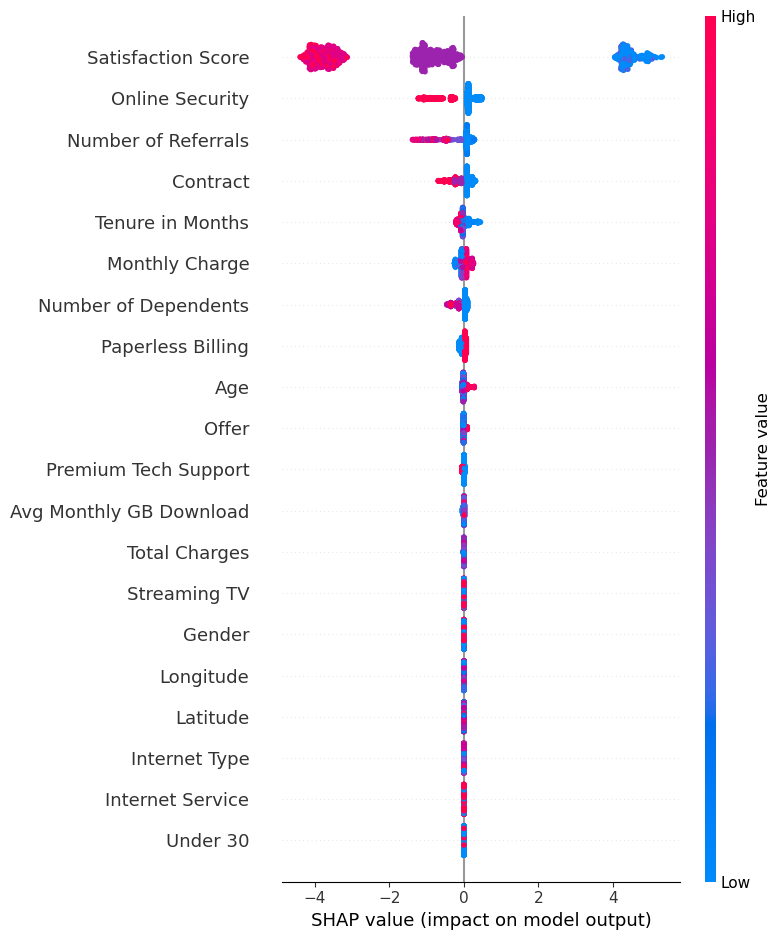

In [301]:
shap.summary_plot(shap_values, X_test)

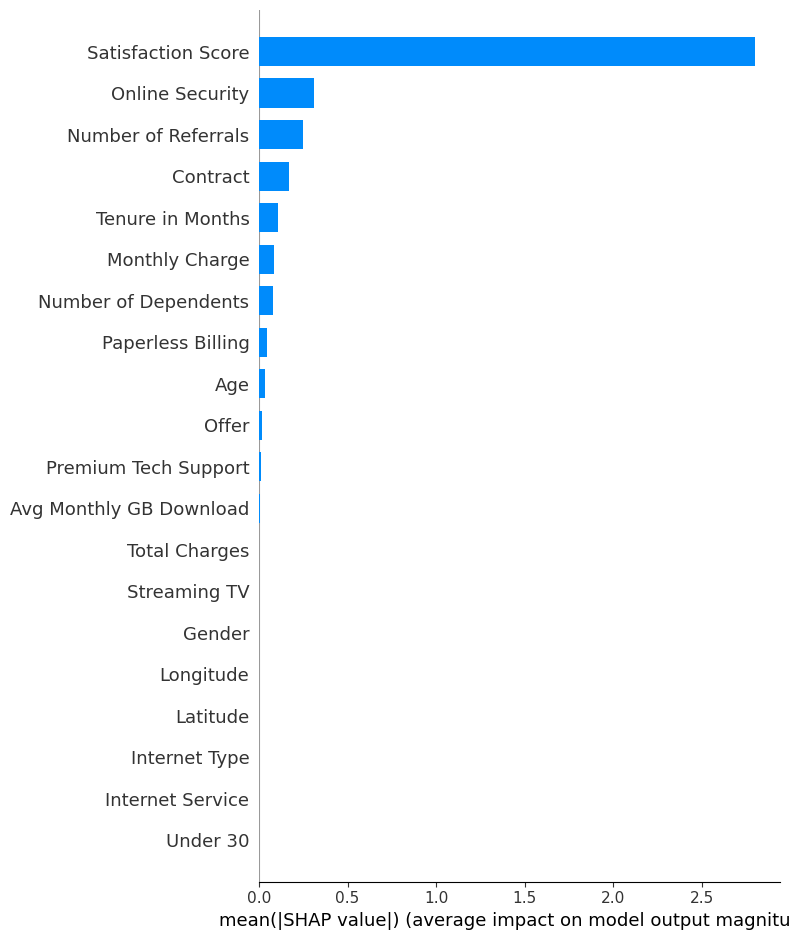

In [302]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


Upon analyzing SHAP values, we observed that Satisfaction Score was the most influential feature in predicting churn by a significant margin. This raised an important question: Is the model overly reliant on this single feature? To evaluate its true predictive power, we tested the model's performance after dropping the Satisfaction Score to see whether it could still generalize effectively.

In [305]:
X_train.drop("Satisfaction Score", axis=1, inplace=True)
X_test.drop("Satisfaction Score", axis=1, inplace=True)

In [306]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [307]:
preds = xgb_cl.predict(X_test)

In [308]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)

print("Model Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Model Accuracy: 0.8401433691756273
Precision: 0.7308868501529052
Recall: 0.6390374331550802
F1 Score: 0.68188302425107

Confusion Matrix:
 [[933  88]
 [135 239]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1021
           1       0.73      0.64      0.68       374

    accuracy                           0.84      1395
   macro avg       0.80      0.78      0.79      1395
weighted avg       0.84      0.84      0.84      1395



In [309]:
train_preds =  xgb_cl.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_preds))

Train Accuracy: 1.0


In [310]:
#Address Overfitting
param_grid = {
    "max_depth": [5],
    "learning_rate": [0, 0.01, 0.05, 0.1],
    "gamma": [1, 5, 10],
    "scale_pos_weight": [2, 5, 10, 20],
    "subsample": [1],
    "colsample_bytree": [1],
    "reg_alpha": [0, 0.1, 1],    # L1 regularization
    "reg_lambda": [1, 5, 10]     # L2 regularization
}

xgb_cl2 = xgb.XGBClassifier(objective="binary:logistic")
grid_cv = GridSearchCV(xgb_cl2, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_ = grid_cv.fit(X_train, y_train)
print("The Best Score:", grid_cv.best_score_)
print("The Best Params:", grid_cv.best_params_)

The Best Score: 0.8962546764088678
The Best Params: {'colsample_bytree': 1, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 0.1, 'reg_lambda': 10, 'scale_pos_weight': 2, 'subsample': 1}


In [317]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_, objective="binary:logistic"
)
grid_final = final_cl.fit(X_train, y_train)
preds = grid_final.predict(X_test)
train_preds =  grid_final.predict(X_train)

In [318]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)

print("Model Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("Train Accuracy:", accuracy_score(y_train, train_preds))

Model Accuracy: 0.832258064516129
Precision: 0.6535087719298246
Recall: 0.7967914438502673
F1 Score: 0.7180722891566266

Confusion Matrix:
 [[863 158]
 [ 76 298]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      1021
           1       0.65      0.80      0.72       374

    accuracy                           0.83      1395
   macro avg       0.79      0.82      0.80      1395
weighted avg       0.85      0.83      0.84      1395

Train Accuracy: 0.8618374558303887


After hyperparameter tuning, we observed improvements in both recall and F1-score, while the overall accuracy remained nearly the same. Notably, the training accuracy dropped from 100% to 86.1%, indicating a significant reduction in overfitting and better generalization to unseen data.

In [313]:
explainer = shap.TreeExplainer(grid_final)

#Calculate SHAP values for your dataset (typically test set or a sample)
shap_values = explainer.shap_values(X_test)

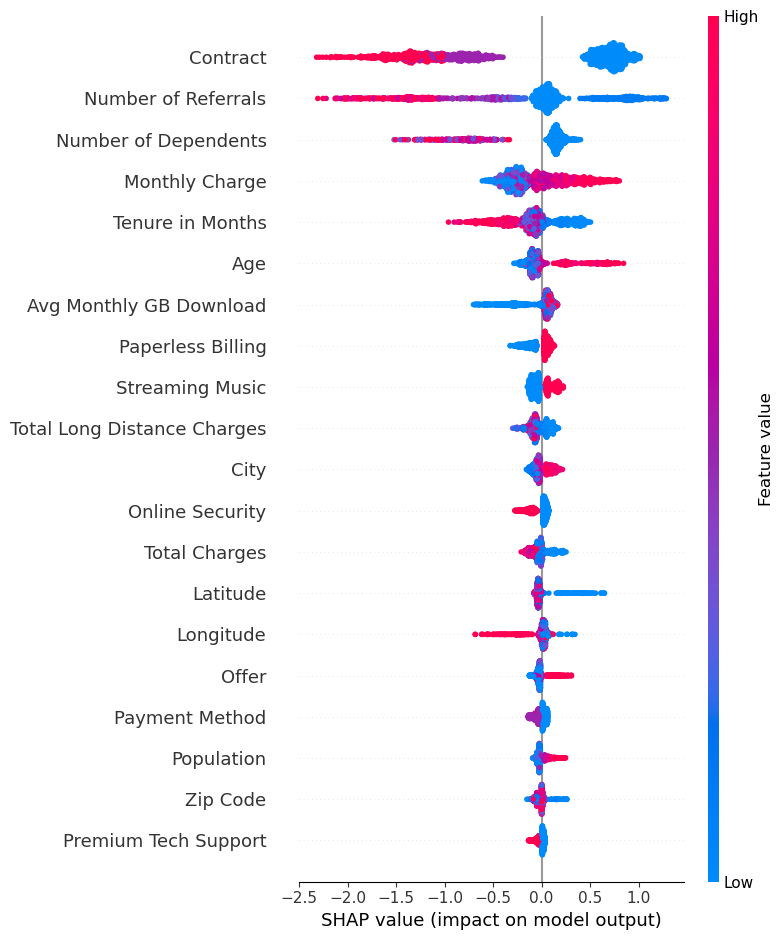

In [314]:
shap.summary_plot(shap_values, X_test)

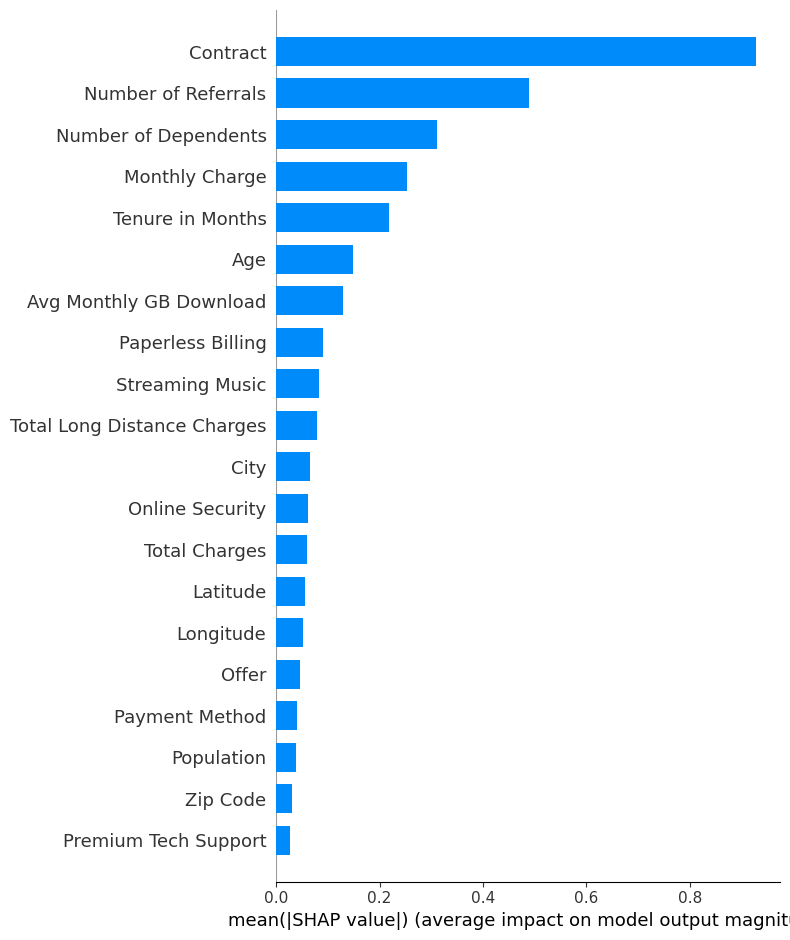

In [315]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### CONCLUSION

The updated model, after removing the Satisfaction Score, achieved an accuracy of 83.2%. While this represents a drop from the previous performance, it confirms that the model can still make meaningful predictions without over-relying on a single feature. Additionally, SHAP analysis now shows a more balanced contribution from multiple features, indicating a more robust and interpretable model.